# Fake-News-Classification

**Group 20**

*Justin Panagakis*

*Yousef Suleiman*

## Steps

1. Preprocess titles by making lowercase, removing punctuation, removing stopwords, and stemming

     - stopwords are common english tokens like "the" and "a"

     - stemming is reducing words to their roots

2. Vectorize each title pair by using TF-IDF and find the cosine distance between them
3. Using `nltk`'s `SentimentIntensityAnalyzer`, create sentiment vectors and calculate the cosine distance between each title pair
4. Count the number of common words between the titles pairs
5. Count the number of frequently used disagreed words (or `fdw`) in the second title

    - `fdw` is a list of the 5 most frequently used words found in "disagreed" titles from title 2 found the training data 
    
6. Build a decision tree to classify the title pairs as `agree`, `disagree`, or `unrelated`

In [1]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import class_weight

from IPython.display import display, clear_output

### Helper Functions for Preprocessing

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

# preprocess a single title
def preprocess_title(title:str):
    # convert to lowercase and remove punctuation
    title = title.lower()
    translator = str.maketrans('', '', string.punctuation)
    title = title.translate(translator)
    # tokenize
    words = nltk.word_tokenize(title)
    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # stem the remaining words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # join the stemmed words back into a single string
    stemmed_title = ' '.join(words)
    return stemmed_title

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yousef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yousef\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# calculates cosine distance between two vectors a b
def cosine_distance(a:list, b:list):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    denom = norm_a * norm_b
    if denom == 0:
        return 0
    return 1 - dot_product / denom

In [4]:
vectorizer = TfidfVectorizer(max_features=100)

# takes 2 titles and returns 2 TF-IDF vectors with default length 16
def tfidf(title1:str, title2:str):
    titles = [title1, title2]
    title_vectors = list(vectorizer.fit_transform(titles).todense().tolist()) 
    return tuple(title_vectors)

def tfidf_distance(title1:str, title2:str):
    tfidf1, tfidf2 = tfidf(title1, title2)
    return cosine_distance(tfidf1, tfidf2)

In [21]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# finds the cosine distance between the sentiments of two titles
# the first return is the cosine distance, the second is the difference between the compounds
def sentiment_distance(title1:str, title2:str):
    s1 = list(sia.polarity_scores(title1).values())
    s2 = list(sia.polarity_scores(title2).values())
    return (cosine_distance(s1[:3], s2[:3]), abs(s1[1] - s2[1]))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yousef\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# compute the intersection of the token sets of two titles
def count_common_words(title1:str, title2:str):
    tokens1 = set(nltk.word_tokenize(title1.lower()))
    tokens2 = set(nltk.word_tokenize(title2.lower()))
    common_words = tokens1.intersection(tokens2)
    return len(common_words)

### Demonstraition of Preprocessing

In [7]:
title1 = preprocess_title('I am a title of a fake news article...')
title2 = preprocess_title('I\'m not really sure if this news title is real?')

vectorizer.fit_transform([title1, title2])
token_labels = vectorizer.get_feature_names_out().tolist()

title_vectors = list(tfidf(title1, title2))

pd.DataFrame(title_vectors, columns=token_labels)

,articl,fake,im,news,real,realli,sure,titl
0,0.576152,0.576152,0.000000,0.409937,0.000000,0.000000,0.000000,0.409937
1,0.000000,0.000000,0.446656,0.317800,0.446656,0.446656,0.446656,0.317800


In [8]:
tfidf_distance(title1, title2)

0.7394443289437376

In [9]:
title1 = 'I am a title of a dumb and fake news article...'
title2 = 'I\'m not really sure if this news title is real but is sure sounds cool?'

sentiment_distance(title1, title2)

0.13084828571329687

In [10]:
title1 = preprocess_title('I am a title of a evil and fake news article...')
title2 = preprocess_title('I\'m also the title of a perhaps evil and fake news article')

count_common_words(title1, title2)

5

### What are the most popular words in "disagreed" articles from Title2?

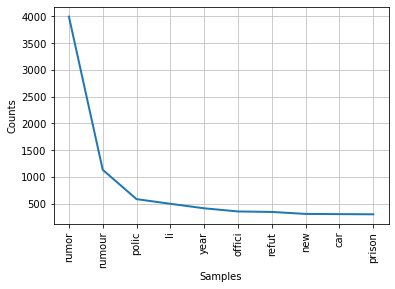

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [37]:
import pandas as pd
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize

# this is the titles that are preprocessed
titles_df = pd.read_csv("preprocessed-titles.csv")

# select only the rows with a class label of 1 "disagreed"
titles_df = titles_df[titles_df['label'] == 1]

# concatenate the titles of all rows into a single string
all_titles = ' '.join(map(str, (titles_df['title2'].tolist())))

# tokenize the string into words
words = word_tokenize(all_titles)

# create a frequency distribution of the words
freq_dist = FreqDist(words)

# select the ten most common words
top_words = freq_dist.most_common(10)

# plot a histogram of the selected words
freq_dist.plot(10)

In [84]:
# this is a list of the "frequently disagreed words"
fdw = [t[0] for t in top_words[:5]]

# returns the count of words in a title that are also in fdw list
def fdw_count(title: str):
    words = title.split()
    count = 0
    for word in words:
        if word in fdw:
            count += 1
    return count

## Preprocessing

In [62]:
df = pd.read_csv('train.csv')
df.head()

,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [22]:
# calculate sentiment distances between each title pair
sentiment_cosine_data = []
sentiment_difference_data = []
for i, row in df.iterrows():
    title1 = row['title1_en']
    title2 = row['title2_en']
    cosine, difference = sentiment_distance(title1, title2)
    sentiment_cosine_data.append(cosine)
    sentiment_difference_data.append(difference)
    
    if i % 100 == 0:
        display(i)
        clear_output(wait=True)

256400

In [ ]:
# preprocess each title pair
titles_df = pd.DataFrame(columns=['title1', 'title2'])

for i, row in df.iterrows():
    # preprocess the titles in the current row
    title1 = preprocess_title(row['title1_en'])
    title2 = preprocess_title(row['title2_en'])
    
    # add the processed titles as a new row to the processed dataframe
    titles_df = pd.concat([titles_df, pd.DataFrame({'title1': [title1], 'title2': [title2]})], ignore_index=True)
    
    if i % 100 == 0:
        display(i)
        clear_output(wait=True)

titles_df['label'] = df['label'].replace({'agreed': 0, 'disagreed': 1, 'unrelated': 2})
titles_df.to_csv('preprocessed-titles.csv', index=False)

In [13]:
# calculate the TF-IDF distances for each title pair and common word count
titles_df = pd.read_csv("preprocessed-titles.csv")
tfidf_data = []
common_word_data = []
for i, row in titles_df.iterrows():
    title1 = str(row['title1'])
    title2 = str(row['title2'])
    
    tfidf_data.append(tfidf_distance(title1, title2))
    common_word_data.append(count_common_words(title1, title2))
    
    if i % 100 == 0:
        display(i)
        clear_output(wait=True)

256400

In [85]:
# calculate the number of words in fdw list
titles_df = pd.read_csv("preprocessed-titles.csv")
fdw_data = []
for title2 in titles_df['title2']:
    fdw_data.append(fdw_count(str(title2)))
print(len(fdw_data))

256442


In [88]:
labels = df['label'].replace({'agreed': 0, 'disagreed': 1, 'unrelated': 2})

train_df = pd.DataFrame()
train_df['sentiment_cosine_distance'] = sentiment_cosine_data
train_df['sentiment_difference_distance'] = sentiment_difference_data
train_df['tfidf_distance'] = tfidf_data
train_df['common_word_count'] = common_word_data
train_df['fdw_count'] = fdw_data
train_df['label'] = labels

train_df.to_csv('train-transformed.csv', index=False)
train_df.describe()

,sentiment_cosine_distance,sentiment_difference_distance,tfidf_distance,common_word_count,fdw_count,label
count,2.564420e+05,256442.000000,2.564420e+05,256442.000000,256442.000000,256442.000000
mean,4.804394e-02,0.148062,8.382615e-01,2.161202,0.369503,1.395255
std,6.945175e-02,0.124897,1.773720e-01,2.172861,0.636686,0.904443
min,-2.220446e-16,0.000000,-2.220446e-16,0.000000,0.000000,0.000000
25%,5.850390e-03,0.044000,7.576423e-01,0.000000,0.000000,0.000000
50%,2.329156e-02,0.128000,8.869592e-01,2.000000,0.000000,2.000000
75%,6.106984e-02,0.221000,1.000000e+00,3.000000,1.000000,2.000000
max,1.000000e+00,1.000000,1.000000e+00,18.000000,11.000000,2.000000


# (Attempted) Training

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_df = pd.read_csv("train-transformed.csv")
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy: 0.9698468947565962


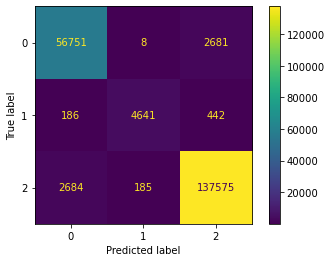

In [91]:
y_pred = tree.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

conf_mat = confusion_matrix(y_train, y_pred)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()

Accuracy: 0.706291797461444


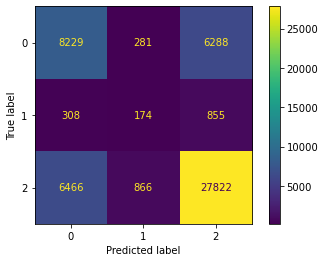

In [92]:
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_mat = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()